In [2]:
from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                    NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)
import sys
import argparse
import pandas as pd
from scipy import sparse
import codecs
import time
import datetime
import tqdm
import numpy as np
import logging
import json
import csv
from collections import Counter
import random
from google.cloud import bigquery
#import threading
#from concurrent import futures
from GleephReco import filterAuthSeries as F
from GleephReco import FilesAndMails as fm
from GleephReco import GlephRecoAuthors as GleephReco
#from google.cloud import pubsub_v1
#from google.cloud.pubsub import types
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Chargement des données

## Données Relations Users - Books

In [62]:
gleephlib_wt_gender = pd.read_csv('./data/gleeph/wtglid_wt_gender.csv')
gleephlib_wo_gender = pd.read_csv('./data/gleeph/wtglid.csv')

/home/jupyter/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Données Matrice U (BPR)

In [63]:
usersdf = pd.read_csv('./data/gleeph/BPRSPACE_users.csv')

In [74]:
usersdf.head()

,Unnamed: 0,peopleNum,people_id,email,0,1,2,3,4,5,...,61,62,63,64,65,66,67,68,69,70
0,0,80174,7B8250C624A24EF08841A9F49825A22A,fabheng@hotmail.com,-0.323548,-0.866178,0.451930,-0.107643,0.767925,-0.185142,...,0.226717,0.610690,0.169628,0.075646,0.377618,-0.020915,0.279207,-0.144205,0.151827,1.0
1,1,147642,E31A3452FC5345EEA0E5782E4F3D191E,nicolas.muzotte@hotmail.fr,-0.623632,0.182170,-0.686277,0.118555,0.659052,-0.558926,...,0.222744,-0.366223,0.849744,0.586217,-0.063489,0.286703,0.627547,0.037664,0.204300,1.0
2,2,114374,B00E152F1DDB47D8B978E2F7B9C7A7C5,musicandmusic08@gmail.com,-0.089403,0.095695,0.399873,0.458050,-0.300125,-0.508864,...,0.411982,-0.612706,0.451794,0.049277,0.828090,-0.150568,-0.726073,0.003145,0.359182,1.0
3,3,29288,2D3FA641425040F28C4743C84FE9AA94,celinebuisson1106@gmail.com,-0.182162,0.254100,0.472662,-0.088145,0.353513,-0.544877,...,0.282244,-0.034745,0.127390,0.350047,-0.078134,0.305226,0.950857,0.179854,0.113252,1.0
4,4,514,00CCA499C46244FDA16713AD88DF1455,oliveklams@gmail.com,-0.347436,0.275488,-0.572120,0.071424,0.045968,-0.172746,...,-0.093188,0.185128,0.575642,0.827476,0.477274,0.427787,0.266620,0.135358,0.355569,1.0


## Données pour exemple matrice creuse

In [64]:
df = gleephlib_wo_gender[['glid','people_id']][(gleephlib_wo_gender['people_id'] == '348D0AA4DC5E40C4B439DBF4C86C877D') | (gleephlib_wo_gender['people_id'] == 'EAD4649FC143416CBA4F0302DF6251FD')]
df

,glid,people_id
0,GL-9782866154097,348D0AA4DC5E40C4B439DBF4C86C877D
1,GL-9782866154097,EAD4649FC143416CBA4F0302DF6251FD
8307,GL-9782756085401,348D0AA4DC5E40C4B439DBF4C86C877D
8324,GL-9782700015454,348D0AA4DC5E40C4B439DBF4C86C877D
18916,GL-9782360810642,348D0AA4DC5E40C4B439DBF4C86C877D
...,...,...
8370104,GL-9782842786908,348D0AA4DC5E40C4B439DBF4C86C877D
8403916,GL-9782094903122,EAD4649FC143416CBA4F0302DF6251FD
8404707,GL-9782070383450,EAD4649FC143416CBA4F0302DF6251FD
8435224,GL-9782070368167,EAD4649FC143416CBA4F0302DF6251FD


In [65]:
df['glid'] = df['glid'].astype('category')
df['glid_num'] = df['glid'].cat.codes
df.head(5)
df_n = df[['glid_num','people_id']]
df_n.set_index('people_id',inplace=True)
df_n.head()

,glid_num
people_id,
348D0AA4DC5E40C4B439DBF4C86C877D,1023
EAD4649FC143416CBA4F0302DF6251FD,1023
348D0AA4DC5E40C4B439DBF4C86C877D,880
348D0AA4DC5E40C4B439DBF4C86C877D,720
348D0AA4DC5E40C4B439DBF4C86C877D,644


In [66]:
df_n.shape

(1241, 1)

In [70]:
pd.get_dummies(df_n, columns=['glid_num'], prefix="book", sparse=True).shape

(1241, 1209)

In [72]:
pd.get_dummies(df_n, columns=['glid_num'], prefix="book", sparse=True).head(5)

,book_-1,book_0,book_1,book_2,book_3,book_4,book_5,book_6,book_7,book_8,...,book_1198,book_1199,book_1200,book_1201,book_1202,book_1203,book_1204,book_1205,book_1206,book_1207
people_id,,,,,,,,,,,,,,,,,,,,,
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EAD4649FC143416CBA4F0302DF6251FD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Sparse matrix visualisation

DEBUG:update_title_pos
DEBUG:not adjusting title pos because title was already placed manually: 1.050000
DEBUG:update_title_pos
DEBUG:title position was updated manually, not adjusting
DEBUG:update_title_pos
DEBUG:title position was updated manually, not adjusting
DEBUG:update_title_pos
DEBUG:title position was updated manually, not adjusting
DEBUG:update_title_pos
DEBUG:title position was updated manually, not adjusting


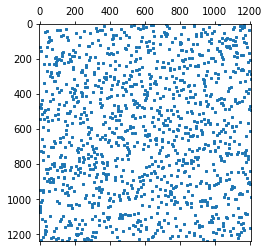

In [61]:
plt.spy(pd.get_dummies(df_n, columns=['glid_num'], prefix="book", sparse=True), precision=0.1, markersize=2)

In [46]:
pd.get_dummies(df_n, columns=['glid_num'], prefix="book", sparse=True)

,book_-1,book_0,book_1,book_2,book_3,book_4,book_5,book_6,book_7,book_8,...,book_1198,book_1199,book_1200,book_1201,book_1202,book_1203,book_1204,book_1205,book_1206,book_1207
people_id,,,,,,,,,,,,,,,,,,,,,
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EAD4649FC143416CBA4F0302DF6251FD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348D0AA4DC5E40C4B439DBF4C86C877D,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EAD4649FC143416CBA4F0302DF6251FD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EAD4649FC143416CBA4F0302DF6251FD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare data

In [67]:
peoples = pd.DataFrame(gleephlib_wt_gender[['people_id','gender']].groupby(by=['people_id'], as_index=False).first())
peoples.set_index('people_id', inplace=True)
usersdf_wt_gender = usersdf.merge(peoples['gender'], on='people_id', how='inner')
usersdf_wt_gender['gender'] = usersdf_wt_gender['gender'].astype('category')
usersdf_wt_gender['gender_code'] = usersdf_wt_gender['gender'].cat.codes
usersdf_wt_gender

,Unnamed: 0,peopleNum,people_id,email,0,1,2,3,4,5,...,63,64,65,66,67,68,69,70,gender,gender_code
0,1,147642,E31A3452FC5345EEA0E5782E4F3D191E,nicolas.muzotte@hotmail.fr,-0.623632,0.182170,-0.686277,0.118555,0.659052,-0.558926,...,0.849744,0.586217,-0.063489,0.286703,0.627547,0.037664,0.204300,1.0,M,1
1,3,29288,2D3FA641425040F28C4743C84FE9AA94,celinebuisson1106@gmail.com,-0.182162,0.254100,0.472662,-0.088145,0.353513,-0.544877,...,0.127390,0.350047,-0.078134,0.305226,0.950857,0.179854,0.113252,1.0,F,0
2,4,514,00CCA499C46244FDA16713AD88DF1455,oliveklams@gmail.com,-0.347436,0.275488,-0.572120,0.071424,0.045968,-0.172746,...,0.575642,0.827476,0.477274,0.427787,0.266620,0.135358,0.355569,1.0,M,1
3,5,10305,100790A0A07B424AA10DB6202E404173,romane.asis@gmail.com,-0.362278,0.902894,-0.099573,0.135585,0.153546,-0.660487,...,0.066106,0.241806,-0.053106,0.447134,-0.015954,0.094282,0.320508,1.0,F,0
4,10,139938,D774D8573F4F407AA58686558D9675DA,marionclarard@gmail.com,-0.637445,0.336528,-0.018371,0.180344,0.450030,-1.063685,...,0.369062,0.052720,0.443346,0.761934,-0.372972,0.178636,0.259284,1.0,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25339,166475,59189,5B500C0E50A64F7CA024005B2C0AFECC,kevin.l.o.m@hotmail.fr,-0.398769,0.041202,0.055888,0.173307,0.305230,0.265722,...,-0.300802,-0.272511,0.307507,0.085156,0.436756,0.030082,-0.280089,1.0,M,1
25340,166483,159998,F62FE8A2A2ED451B8C17FE99300CDE84,couturiern_bsp@me.com,-0.022435,0.169776,0.191049,-0.127877,0.326380,-0.141209,...,-0.063801,-0.079900,0.058971,0.308116,0.131272,0.049631,0.259762,1.0,M,1
25341,166484,87025,85FE5DA3A27545C69F43D25CE762A01D,taxigege@hotmail.fr,-0.030473,0.167601,0.170633,-0.135863,0.342496,-0.135661,...,-0.093991,-0.065962,0.044188,0.302819,0.129016,0.070564,0.271948,1.0,M,1
25342,166489,140334,D80223A0A22A4F67ADAC5494E166551F,henri.lebozec@gmail.com,-0.118931,0.408942,-0.017722,-0.300930,0.397525,-0.138034,...,0.116177,0.221359,-0.048881,0.323168,0.418552,-0.039893,0.064592,1.0,M,1


TSNE. lr: 5  p: 64  n: 3


DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos


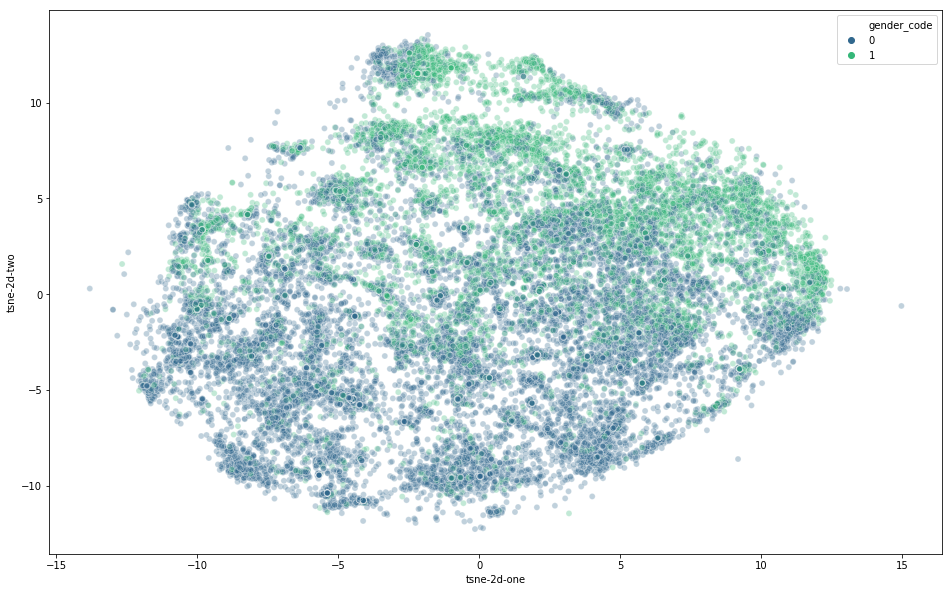

In [68]:
def plottnse(X_embedded,params):
    f=pd.DataFrame()
    f['tsne-2d-one'] = X_embedded[:,0]
    f['tsne-2d-two'] = X_embedded[:,1]
    f['gender_code'] = usersdf_wt_gender['gender_code']
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="gender_code",
        palette=sns.color_palette("viridis", n_colors=2),
        data=f,
        legend="full",
        alpha=0.3
    )
    plt.savefig("tsne-"+params+"-ee24.png")
    
hp = {"params":[
        {"lr":100, "perplexity":20, "n_jobs":-1},
        {"lr":200, "perplexity":20, "n_jobs":-1},
        {"lr":500, "perplexity":20, "n_jobs":-1},
        {"lr":1000, "perplexity":20, "n_jobs":-1},
        {"lr":100, "perplexity":30, "n_jobs":-1},
        {"lr":200, "perplexity":30, "n_jobs":-1},
        {"lr":500, "perplexity":30, "n_jobs":-1},
        {"lr":1000, "perplexity":30, "n_jobs":-1},
        {"lr":100, "perplexity":40, "n_jobs":-1},
        {"lr":200, "perplexity":40, "n_jobs":-1},
        {"lr":500, "perplexity":40, "n_jobs":-1},
        {"lr":1000, "perplexity":40, "n_jobs":-1}
]}
hp = {"params":[
        {"lr":5, "perplexity":64, "n_jobs":3}
]}
for entry in hp['params']:
    lr = entry['lr']
    p = entry['perplexity']
    n = entry['n_jobs']
    print("TSNE. lr:", lr, " p:", p, " n:", n)
    X_embedded = TSNE(n_components=2, learning_rate=lr, init="pca", n_iter=1000, perplexity=p, n_jobs=n, early_exaggeration=12).fit_transform(usersdf_wt_gender.iloc[:,4:75])
    plottnse(X_embedded,"lr"+str(lr)+"_p"+str(p)+"_n"+str(n))

In [75]:
X_embedded

array([[10.6382885,  4.8260465],
       [ 8.242495 ,  5.492433 ],
       [-1.7743212,  2.728725 ],
       ...,
       [ 6.870731 ,  4.743948 ],
       [ 8.511483 ,  4.787765 ],
       [ 2.0926218,  3.7683468]], dtype=float32)

DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos


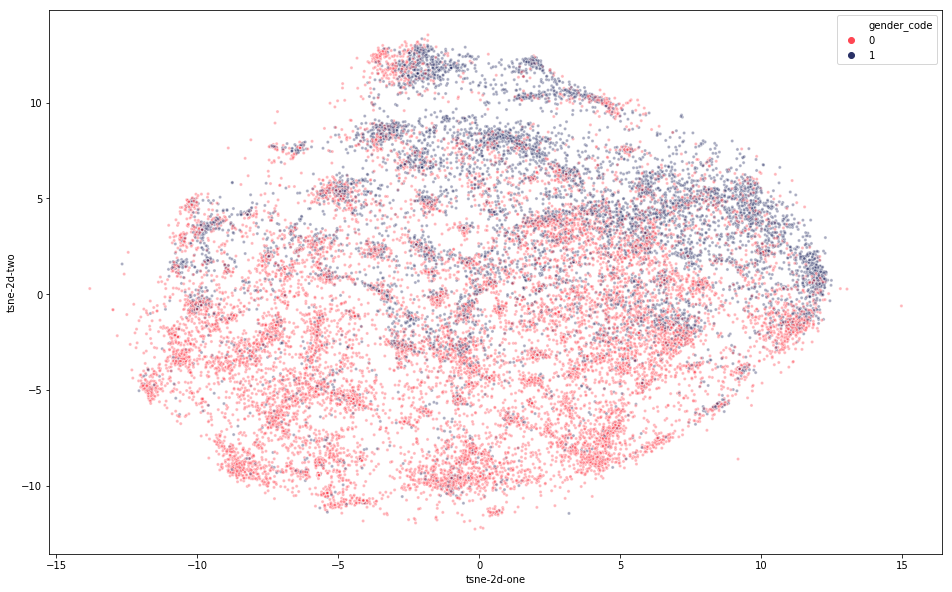

In [73]:
my_colors = ['#FF4653','#2A3166']
def plottnse(X_embedded,params):
    f=pd.DataFrame()
    f['tsne-2d-one'] = X_embedded[:,0]
    f['tsne-2d-two'] = X_embedded[:,1]
    f['gender_code'] = usersdf_wt_gender['gender_code']
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="gender_code",
        palette=sns.color_palette(my_colors,n_colors=2),
        data=f,
        s=10,
        legend="full",
        alpha=0.4
    )
    plt.savefig("tsne-"+params+"-ee24.png")
plottnse(X_embedded,"lr"+str(lr)+"_p"+str(p)+"_n"+str(n))